# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 274.1722 - y1_output_loss: 128.6457 - y2_output_loss: 143.8737 - y1_output_root_mean_squared_error: 11.3799 - y2_output_root_mean_squared_error: 12.0279 - val_loss: 77.0378 - val_y1_output_loss: 17.6388 - val_y2_output_loss: 63.5103 - val_y1_output_root_mean_squared_error: 4.1548 - val_y2_output_root_mean_squared_error: 7.7314
Epoch 2/500
614/614 [==============================] - 0s 153us/sample - loss: 32.2099 - y1_output_loss: 12.7032 - y2_output_loss: 19.3108 - y1_output_root_mean_squared_error: 3.5783 - y2_output_root_mean_squared_error: 4.4052 - val_loss: 22.9869 - val_y1_output_loss: 9.3204 - val_y2_output_loss: 13.9134 - val_y1_output_root_mean_squared_error: 3.0867 - val_y2_output_root_mean_squared_error: 3.6687
Epoch 3/500
614/614 [==============================] - 0s 165us/sample - loss: 27.4763 - y1_output_loss: 10.5359 - y2_output_loss: 16.9146 - y1_ou

614/614 [==============================] - 0s 141us/sample - loss: 14.2312 - y1_output_loss: 5.5832 - y2_output_loss: 9.2846 - y1_output_root_mean_squared_error: 2.3200 - y2_output_root_mean_squared_error: 2.9747 - val_loss: 129.3001 - val_y1_output_loss: 19.7201 - val_y2_output_loss: 112.8536 - val_y1_output_root_mean_squared_error: 4.3752 - val_y2_output_root_mean_squared_error: 10.4956
Epoch 22/500
614/614 [==============================] - 0s 146us/sample - loss: 15.8671 - y1_output_loss: 5.4182 - y2_output_loss: 10.4576 - y1_output_root_mean_squared_error: 2.3252 - y2_output_root_mean_squared_error: 3.2343 - val_loss: 10.2533 - val_y1_output_loss: 4.1573 - val_y2_output_loss: 6.0454 - val_y1_output_root_mean_squared_error: 2.0529 - val_y2_output_root_mean_squared_error: 2.4574
Epoch 23/500
614/614 [==============================] - 0s 147us/sample - loss: 12.6993 - y1_output_loss: 4.8143 - y2_output_loss: 7.9338 - y1_output_root_mean_squared_error: 2.1933 - y2_output_root_mean_squ

Epoch 42/500
614/614 [==============================] - 0s 144us/sample - loss: 6.9697 - y1_output_loss: 2.1250 - y2_output_loss: 4.8190 - y1_output_root_mean_squared_error: 1.4640 - y2_output_root_mean_squared_error: 2.1969 - val_loss: 8.8317 - val_y1_output_loss: 2.1769 - val_y2_output_loss: 6.5860 - val_y1_output_root_mean_squared_error: 1.4913 - val_y2_output_root_mean_squared_error: 2.5705
Epoch 43/500
614/614 [==============================] - 0s 155us/sample - loss: 6.3241 - y1_output_loss: 1.8304 - y2_output_loss: 4.4663 - y1_output_root_mean_squared_error: 1.3560 - y2_output_root_mean_squared_error: 2.1179 - val_loss: 4.7075 - val_y1_output_loss: 1.2840 - val_y2_output_loss: 3.3743 - val_y1_output_root_mean_squared_error: 1.1311 - val_y2_output_root_mean_squared_error: 1.8515
Epoch 44/500
614/614 [==============================] - 0s 148us/sample - loss: 6.0284 - y1_output_loss: 1.8661 - y2_output_loss: 4.2375 - y1_output_root_mean_squared_error: 1.3714 - y2_output_root_mean_s

Epoch 63/500
614/614 [==============================] - 0s 157us/sample - loss: 5.0342 - y1_output_loss: 1.2187 - y2_output_loss: 3.7757 - y1_output_root_mean_squared_error: 1.1065 - y2_output_root_mean_squared_error: 1.9519 - val_loss: 3.4458 - val_y1_output_loss: 0.6353 - val_y2_output_loss: 2.7054 - val_y1_output_root_mean_squared_error: 0.8084 - val_y2_output_root_mean_squared_error: 1.6710
Epoch 64/500
614/614 [==============================] - 0s 155us/sample - loss: 4.4975 - y1_output_loss: 1.2488 - y2_output_loss: 3.2562 - y1_output_root_mean_squared_error: 1.1200 - y2_output_root_mean_squared_error: 1.8008 - val_loss: 14.3582 - val_y1_output_loss: 3.2549 - val_y2_output_loss: 11.4329 - val_y1_output_root_mean_squared_error: 1.7820 - val_y2_output_root_mean_squared_error: 3.3440
Epoch 65/500
614/614 [==============================] - 0s 151us/sample - loss: 5.5249 - y1_output_loss: 1.5340 - y2_output_loss: 3.9626 - y1_output_root_mean_squared_error: 1.2433 - y2_output_root_mean

Epoch 84/500
614/614 [==============================] - 0s 151us/sample - loss: 3.9850 - y1_output_loss: 1.0842 - y2_output_loss: 2.8782 - y1_output_root_mean_squared_error: 1.0451 - y2_output_root_mean_squared_error: 1.7008 - val_loss: 4.6199 - val_y1_output_loss: 0.4374 - val_y2_output_loss: 4.1695 - val_y1_output_root_mean_squared_error: 0.6653 - val_y2_output_root_mean_squared_error: 2.0438
Epoch 85/500
614/614 [==============================] - 0s 144us/sample - loss: 12.6896 - y1_output_loss: 3.9531 - y2_output_loss: 8.6487 - y1_output_root_mean_squared_error: 1.9933 - y2_output_root_mean_squared_error: 2.9524 - val_loss: 5.4812 - val_y1_output_loss: 1.9035 - val_y2_output_loss: 3.5881 - val_y1_output_root_mean_squared_error: 1.3636 - val_y2_output_root_mean_squared_error: 1.9031
Epoch 86/500
614/614 [==============================] - 0s 149us/sample - loss: 3.6396 - y1_output_loss: 0.9656 - y2_output_loss: 2.6627 - y1_output_root_mean_squared_error: 0.9857 - y2_output_root_mean_

Epoch 105/500
614/614 [==============================] - 0s 140us/sample - loss: 2.9820 - y1_output_loss: 0.7224 - y2_output_loss: 2.2316 - y1_output_root_mean_squared_error: 0.8538 - y2_output_root_mean_squared_error: 1.5010 - val_loss: 2.2972 - val_y1_output_loss: 0.3794 - val_y2_output_loss: 1.8506 - val_y1_output_root_mean_squared_error: 0.6236 - val_y2_output_root_mean_squared_error: 1.3814
Epoch 106/500
614/614 [==============================] - 0s 146us/sample - loss: 2.4064 - y1_output_loss: 0.6443 - y2_output_loss: 1.8031 - y1_output_root_mean_squared_error: 0.7954 - y2_output_root_mean_squared_error: 1.3318 - val_loss: 3.1200 - val_y1_output_loss: 0.4748 - val_y2_output_loss: 2.5884 - val_y1_output_root_mean_squared_error: 0.6901 - val_y2_output_root_mean_squared_error: 1.6260
Epoch 107/500
614/614 [==============================] - 0s 147us/sample - loss: 2.3749 - y1_output_loss: 0.5515 - y2_output_loss: 1.8652 - y1_output_root_mean_squared_error: 0.7418 - y2_output_root_mea

614/614 [==============================] - 0s 148us/sample - loss: 2.0786 - y1_output_loss: 0.4735 - y2_output_loss: 1.5976 - y1_output_root_mean_squared_error: 0.6906 - y2_output_root_mean_squared_error: 1.2656 - val_loss: 2.1812 - val_y1_output_loss: 0.3763 - val_y2_output_loss: 1.7939 - val_y1_output_root_mean_squared_error: 0.5973 - val_y2_output_root_mean_squared_error: 1.3507
Epoch 126/500
614/614 [==============================] - 0s 146us/sample - loss: 2.4790 - y1_output_loss: 0.6678 - y2_output_loss: 1.8060 - y1_output_root_mean_squared_error: 0.8160 - y2_output_root_mean_squared_error: 1.3465 - val_loss: 3.8560 - val_y1_output_loss: 0.9229 - val_y2_output_loss: 3.0233 - val_y1_output_root_mean_squared_error: 0.9288 - val_y2_output_root_mean_squared_error: 1.7301
Epoch 127/500
614/614 [==============================] - 0s 139us/sample - loss: 1.9063 - y1_output_loss: 0.4415 - y2_output_loss: 1.4655 - y1_output_root_mean_squared_error: 0.6671 - y2_output_root_mean_squared_erro

Epoch 146/500
614/614 [==============================] - 0s 155us/sample - loss: 2.0933 - y1_output_loss: 0.5648 - y2_output_loss: 1.5227 - y1_output_root_mean_squared_error: 0.7520 - y2_output_root_mean_squared_error: 1.2360 - val_loss: 2.1214 - val_y1_output_loss: 0.3642 - val_y2_output_loss: 1.7656 - val_y1_output_root_mean_squared_error: 0.5904 - val_y2_output_root_mean_squared_error: 1.3315
Epoch 147/500
614/614 [==============================] - 0s 143us/sample - loss: 1.7284 - y1_output_loss: 0.3292 - y2_output_loss: 1.3849 - y1_output_root_mean_squared_error: 0.5755 - y2_output_root_mean_squared_error: 1.1820 - val_loss: 1.8570 - val_y1_output_loss: 0.2515 - val_y2_output_loss: 1.5516 - val_y1_output_root_mean_squared_error: 0.5025 - val_y2_output_root_mean_squared_error: 1.2667
Epoch 148/500
614/614 [==============================] - 0s 144us/sample - loss: 2.1272 - y1_output_loss: 0.5222 - y2_output_loss: 1.6556 - y1_output_root_mean_squared_error: 0.7062 - y2_output_root_mea

614/614 [==============================] - 0s 146us/sample - loss: 1.6708 - y1_output_loss: 0.4307 - y2_output_loss: 1.2370 - y1_output_root_mean_squared_error: 0.6538 - y2_output_root_mean_squared_error: 1.1151 - val_loss: 2.1676 - val_y1_output_loss: 0.4227 - val_y2_output_loss: 1.6920 - val_y1_output_root_mean_squared_error: 0.6510 - val_y2_output_root_mean_squared_error: 1.3205
Epoch 167/500
614/614 [==============================] - 0s 145us/sample - loss: 1.6591 - y1_output_loss: 0.3108 - y2_output_loss: 1.3707 - y1_output_root_mean_squared_error: 0.5530 - y2_output_root_mean_squared_error: 1.1633 - val_loss: 3.2027 - val_y1_output_loss: 0.4143 - val_y2_output_loss: 2.7601 - val_y1_output_root_mean_squared_error: 0.6424 - val_y2_output_root_mean_squared_error: 1.6703
Epoch 168/500
614/614 [==============================] - 0s 145us/sample - loss: 1.8272 - y1_output_loss: 0.3515 - y2_output_loss: 1.4980 - y1_output_root_mean_squared_error: 0.5947 - y2_output_root_mean_squared_erro

Epoch 187/500
614/614 [==============================] - 0s 137us/sample - loss: 1.7944 - y1_output_loss: 0.3448 - y2_output_loss: 1.4565 - y1_output_root_mean_squared_error: 0.5867 - y2_output_root_mean_squared_error: 1.2042 - val_loss: 3.6276 - val_y1_output_loss: 0.2810 - val_y2_output_loss: 3.2846 - val_y1_output_root_mean_squared_error: 0.5355 - val_y2_output_root_mean_squared_error: 1.8278
Epoch 188/500
614/614 [==============================] - 0s 144us/sample - loss: 1.2790 - y1_output_loss: 0.2836 - y2_output_loss: 1.0308 - y1_output_root_mean_squared_error: 0.5322 - y2_output_root_mean_squared_error: 0.9979 - val_loss: 2.0959 - val_y1_output_loss: 0.3370 - val_y2_output_loss: 1.7543 - val_y1_output_root_mean_squared_error: 0.5757 - val_y2_output_root_mean_squared_error: 1.3283
Epoch 189/500
614/614 [==============================] - 0s 149us/sample - loss: 1.1959 - y1_output_loss: 0.2298 - y2_output_loss: 0.9688 - y1_output_root_mean_squared_error: 0.4811 - y2_output_root_mea

614/614 [==============================] - 0s 156us/sample - loss: 1.1321 - y1_output_loss: 0.2353 - y2_output_loss: 0.8894 - y1_output_root_mean_squared_error: 0.4863 - y2_output_root_mean_squared_error: 0.9463 - val_loss: 1.4929 - val_y1_output_loss: 0.1990 - val_y2_output_loss: 1.2521 - val_y1_output_root_mean_squared_error: 0.4481 - val_y2_output_root_mean_squared_error: 1.1367
Epoch 208/500
614/614 [==============================] - 0s 145us/sample - loss: 1.0869 - y1_output_loss: 0.2036 - y2_output_loss: 0.8815 - y1_output_root_mean_squared_error: 0.4525 - y2_output_root_mean_squared_error: 0.9392 - val_loss: 1.6298 - val_y1_output_loss: 0.2938 - val_y2_output_loss: 1.3225 - val_y1_output_root_mean_squared_error: 0.5275 - val_y2_output_root_mean_squared_error: 1.1626
Epoch 209/500
614/614 [==============================] - 0s 179us/sample - loss: 1.2395 - y1_output_loss: 0.2394 - y2_output_loss: 0.9917 - y1_output_root_mean_squared_error: 0.4901 - y2_output_root_mean_squared_erro

Epoch 228/500
614/614 [==============================] - 0s 158us/sample - loss: 1.0338 - y1_output_loss: 0.2138 - y2_output_loss: 0.8223 - y1_output_root_mean_squared_error: 0.4640 - y2_output_root_mean_squared_error: 0.9047 - val_loss: 1.5346 - val_y1_output_loss: 0.2089 - val_y2_output_loss: 1.3120 - val_y1_output_root_mean_squared_error: 0.4491 - val_y2_output_root_mean_squared_error: 1.1545
Epoch 229/500
614/614 [==============================] - 0s 159us/sample - loss: 1.1968 - y1_output_loss: 0.2516 - y2_output_loss: 0.9452 - y1_output_root_mean_squared_error: 0.5035 - y2_output_root_mean_squared_error: 0.9713 - val_loss: 2.5578 - val_y1_output_loss: 0.4164 - val_y2_output_loss: 2.2192 - val_y1_output_root_mean_squared_error: 0.6177 - val_y2_output_root_mean_squared_error: 1.4752
Epoch 230/500
614/614 [==============================] - 0s 155us/sample - loss: 1.2887 - y1_output_loss: 0.2524 - y2_output_loss: 1.0352 - y1_output_root_mean_squared_error: 0.5031 - y2_output_root_mea

614/614 [==============================] - 0s 147us/sample - loss: 1.0977 - y1_output_loss: 0.2058 - y2_output_loss: 0.8829 - y1_output_root_mean_squared_error: 0.4542 - y2_output_root_mean_squared_error: 0.9441 - val_loss: 1.5422 - val_y1_output_loss: 0.2025 - val_y2_output_loss: 1.2942 - val_y1_output_root_mean_squared_error: 0.4461 - val_y2_output_root_mean_squared_error: 1.1590
Epoch 249/500
614/614 [==============================] - 0s 142us/sample - loss: 1.3392 - y1_output_loss: 0.2411 - y2_output_loss: 1.0876 - y1_output_root_mean_squared_error: 0.4917 - y2_output_root_mean_squared_error: 1.0476 - val_loss: 1.4345 - val_y1_output_loss: 0.2755 - val_y2_output_loss: 1.1441 - val_y1_output_root_mean_squared_error: 0.5172 - val_y2_output_root_mean_squared_error: 1.0803
Epoch 250/500
614/614 [==============================] - 0s 146us/sample - loss: 1.0529 - y1_output_loss: 0.2082 - y2_output_loss: 0.8407 - y1_output_root_mean_squared_error: 0.4559 - y2_output_root_mean_squared_erro

Epoch 269/500
614/614 [==============================] - 0s 160us/sample - loss: 1.1030 - y1_output_loss: 0.2373 - y2_output_loss: 0.8715 - y1_output_root_mean_squared_error: 0.4757 - y2_output_root_mean_squared_error: 0.9363 - val_loss: 1.8455 - val_y1_output_loss: 0.4367 - val_y2_output_loss: 1.4066 - val_y1_output_root_mean_squared_error: 0.6519 - val_y2_output_root_mean_squared_error: 1.1918
Epoch 270/500
614/614 [==============================] - 0s 160us/sample - loss: 1.2201 - y1_output_loss: 0.2509 - y2_output_loss: 0.9645 - y1_output_root_mean_squared_error: 0.5011 - y2_output_root_mean_squared_error: 0.9844 - val_loss: 1.7633 - val_y1_output_loss: 0.3549 - val_y2_output_loss: 1.3697 - val_y1_output_root_mean_squared_error: 0.6017 - val_y2_output_root_mean_squared_error: 1.1837
Epoch 271/500
614/614 [==============================] - 0s 162us/sample - loss: 1.1615 - y1_output_loss: 0.2226 - y2_output_loss: 0.9350 - y1_output_root_mean_squared_error: 0.4718 - y2_output_root_mea

614/614 [==============================] - 0s 161us/sample - loss: 0.9830 - y1_output_loss: 0.2317 - y2_output_loss: 0.7562 - y1_output_root_mean_squared_error: 0.4712 - y2_output_root_mean_squared_error: 0.8723 - val_loss: 2.0567 - val_y1_output_loss: 0.4974 - val_y2_output_loss: 1.4969 - val_y1_output_root_mean_squared_error: 0.7168 - val_y2_output_root_mean_squared_error: 1.2422
Epoch 290/500
614/614 [==============================] - 0s 159us/sample - loss: 1.2639 - y1_output_loss: 0.2529 - y2_output_loss: 1.0071 - y1_output_root_mean_squared_error: 0.5048 - y2_output_root_mean_squared_error: 1.0045 - val_loss: 1.2960 - val_y1_output_loss: 0.1857 - val_y2_output_loss: 1.0719 - val_y1_output_root_mean_squared_error: 0.4328 - val_y2_output_root_mean_squared_error: 1.0529
Epoch 291/500
614/614 [==============================] - 0s 164us/sample - loss: 1.0339 - y1_output_loss: 0.2064 - y2_output_loss: 0.8254 - y1_output_root_mean_squared_error: 0.4541 - y2_output_root_mean_squared_erro

Epoch 310/500
614/614 [==============================] - 0s 149us/sample - loss: 0.8699 - y1_output_loss: 0.1761 - y2_output_loss: 0.6866 - y1_output_root_mean_squared_error: 0.4215 - y2_output_root_mean_squared_error: 0.8320 - val_loss: 1.3726 - val_y1_output_loss: 0.2234 - val_y2_output_loss: 1.1044 - val_y1_output_root_mean_squared_error: 0.4801 - val_y2_output_root_mean_squared_error: 1.0687
Epoch 311/500
614/614 [==============================] - 0s 149us/sample - loss: 0.8369 - y1_output_loss: 0.1669 - y2_output_loss: 0.6644 - y1_output_root_mean_squared_error: 0.4098 - y2_output_root_mean_squared_error: 0.8179 - val_loss: 1.3135 - val_y1_output_loss: 0.2817 - val_y2_output_loss: 1.0311 - val_y1_output_root_mean_squared_error: 0.5078 - val_y2_output_root_mean_squared_error: 1.0274
Epoch 312/500
614/614 [==============================] - 0s 161us/sample - loss: 1.1053 - y1_output_loss: 0.2181 - y2_output_loss: 0.8896 - y1_output_root_mean_squared_error: 0.4689 - y2_output_root_mea

614/614 [==============================] - 0s 146us/sample - loss: 1.1942 - y1_output_loss: 0.2268 - y2_output_loss: 0.9683 - y1_output_root_mean_squared_error: 0.4732 - y2_output_root_mean_squared_error: 0.9850 - val_loss: 2.6194 - val_y1_output_loss: 0.3151 - val_y2_output_loss: 2.2391 - val_y1_output_root_mean_squared_error: 0.5668 - val_y2_output_root_mean_squared_error: 1.5160
Epoch 331/500
614/614 [==============================] - 0s 144us/sample - loss: 0.8294 - y1_output_loss: 0.1953 - y2_output_loss: 0.6346 - y1_output_root_mean_squared_error: 0.4425 - y2_output_root_mean_squared_error: 0.7960 - val_loss: 1.4721 - val_y1_output_loss: 0.2386 - val_y2_output_loss: 1.2015 - val_y1_output_root_mean_squared_error: 0.4843 - val_y2_output_root_mean_squared_error: 1.1125
Epoch 332/500
614/614 [==============================] - 0s 144us/sample - loss: 0.9291 - y1_output_loss: 0.2109 - y2_output_loss: 0.7163 - y1_output_root_mean_squared_error: 0.4601 - y2_output_root_mean_squared_erro

Epoch 351/500
614/614 [==============================] - 0s 158us/sample - loss: 0.8455 - y1_output_loss: 0.1856 - y2_output_loss: 0.6711 - y1_output_root_mean_squared_error: 0.4304 - y2_output_root_mean_squared_error: 0.8126 - val_loss: 3.8963 - val_y1_output_loss: 0.3899 - val_y2_output_loss: 3.6049 - val_y1_output_root_mean_squared_error: 0.5983 - val_y2_output_root_mean_squared_error: 1.8810
Epoch 352/500
614/614 [==============================] - 0s 153us/sample - loss: 0.9914 - y1_output_loss: 0.2887 - y2_output_loss: 0.6946 - y1_output_root_mean_squared_error: 0.5391 - y2_output_root_mean_squared_error: 0.8371 - val_loss: 1.2619 - val_y1_output_loss: 0.2030 - val_y2_output_loss: 1.0264 - val_y1_output_root_mean_squared_error: 0.4491 - val_y2_output_root_mean_squared_error: 1.0297
Epoch 353/500
614/614 [==============================] - 0s 155us/sample - loss: 0.7289 - y1_output_loss: 0.1603 - y2_output_loss: 0.5649 - y1_output_root_mean_squared_error: 0.4015 - y2_output_root_mea

614/614 [==============================] - 0s 153us/sample - loss: 0.6488 - y1_output_loss: 0.1507 - y2_output_loss: 0.5007 - y1_output_root_mean_squared_error: 0.3864 - y2_output_root_mean_squared_error: 0.7067 - val_loss: 1.1409 - val_y1_output_loss: 0.2270 - val_y2_output_loss: 0.9208 - val_y1_output_root_mean_squared_error: 0.4581 - val_y2_output_root_mean_squared_error: 0.9649
Epoch 372/500
614/614 [==============================] - 0s 155us/sample - loss: 0.6810 - y1_output_loss: 0.1444 - y2_output_loss: 0.5362 - y1_output_root_mean_squared_error: 0.3808 - y2_output_root_mean_squared_error: 0.7321 - val_loss: 1.4379 - val_y1_output_loss: 0.2425 - val_y2_output_loss: 1.2159 - val_y1_output_root_mean_squared_error: 0.4692 - val_y2_output_root_mean_squared_error: 1.1035
Epoch 373/500
614/614 [==============================] - 0s 148us/sample - loss: 0.8628 - y1_output_loss: 0.1895 - y2_output_loss: 0.6683 - y1_output_root_mean_squared_error: 0.4343 - y2_output_root_mean_squared_erro

Epoch 392/500
614/614 [==============================] - 0s 153us/sample - loss: 0.6386 - y1_output_loss: 0.1391 - y2_output_loss: 0.4947 - y1_output_root_mean_squared_error: 0.3743 - y2_output_root_mean_squared_error: 0.7060 - val_loss: 1.0721 - val_y1_output_loss: 0.1981 - val_y2_output_loss: 0.8578 - val_y1_output_root_mean_squared_error: 0.4505 - val_y2_output_root_mean_squared_error: 0.9323
Epoch 393/500
614/614 [==============================] - 0s 141us/sample - loss: 0.6349 - y1_output_loss: 0.1503 - y2_output_loss: 0.4809 - y1_output_root_mean_squared_error: 0.3891 - y2_output_root_mean_squared_error: 0.6953 - val_loss: 1.2438 - val_y1_output_loss: 0.1803 - val_y2_output_loss: 1.0321 - val_y1_output_root_mean_squared_error: 0.4230 - val_y2_output_root_mean_squared_error: 1.0319
Epoch 394/500
614/614 [==============================] - 0s 151us/sample - loss: 0.5953 - y1_output_loss: 0.1500 - y2_output_loss: 0.4473 - y1_output_root_mean_squared_error: 0.3881 - y2_output_root_mea

614/614 [==============================] - 0s 151us/sample - loss: 0.6035 - y1_output_loss: 0.1378 - y2_output_loss: 0.4680 - y1_output_root_mean_squared_error: 0.3714 - y2_output_root_mean_squared_error: 0.6823 - val_loss: 1.1818 - val_y1_output_loss: 0.1841 - val_y2_output_loss: 0.9813 - val_y1_output_root_mean_squared_error: 0.4218 - val_y2_output_root_mean_squared_error: 1.0019
Epoch 413/500
614/614 [==============================] - 0s 156us/sample - loss: 0.7160 - y1_output_loss: 0.1616 - y2_output_loss: 0.5502 - y1_output_root_mean_squared_error: 0.4029 - y2_output_root_mean_squared_error: 0.7441 - val_loss: 1.1228 - val_y1_output_loss: 0.1758 - val_y2_output_loss: 0.9172 - val_y1_output_root_mean_squared_error: 0.4246 - val_y2_output_root_mean_squared_error: 0.9708
Epoch 414/500
614/614 [==============================] - 0s 144us/sample - loss: 0.6005 - y1_output_loss: 0.1389 - y2_output_loss: 0.4573 - y1_output_root_mean_squared_error: 0.3739 - y2_output_root_mean_squared_erro

Epoch 433/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5598 - y1_output_loss: 0.1431 - y2_output_loss: 0.4199 - y1_output_root_mean_squared_error: 0.3798 - y2_output_root_mean_squared_error: 0.6446 - val_loss: 1.6112 - val_y1_output_loss: 0.2130 - val_y2_output_loss: 1.4079 - val_y1_output_root_mean_squared_error: 0.4462 - val_y2_output_root_mean_squared_error: 1.1883
Epoch 434/500
614/614 [==============================] - 0s 147us/sample - loss: 0.6208 - y1_output_loss: 0.1390 - y2_output_loss: 0.4768 - y1_output_root_mean_squared_error: 0.3740 - y2_output_root_mean_squared_error: 0.6935 - val_loss: 0.9044 - val_y1_output_loss: 0.1715 - val_y2_output_loss: 0.7076 - val_y1_output_root_mean_squared_error: 0.4172 - val_y2_output_root_mean_squared_error: 0.8546
Epoch 435/500
614/614 [==============================] - 0s 156us/sample - loss: 0.5081 - y1_output_loss: 0.1251 - y2_output_loss: 0.3785 - y1_output_root_mean_squared_error: 0.3551 - y2_output_root_mea

614/614 [==============================] - 0s 155us/sample - loss: 0.6554 - y1_output_loss: 0.1594 - y2_output_loss: 0.4916 - y1_output_root_mean_squared_error: 0.4003 - y2_output_root_mean_squared_error: 0.7037 - val_loss: 1.4722 - val_y1_output_loss: 0.2881 - val_y2_output_loss: 1.1514 - val_y1_output_root_mean_squared_error: 0.5450 - val_y2_output_root_mean_squared_error: 1.0841
Epoch 454/500
614/614 [==============================] - 0s 155us/sample - loss: 0.5170 - y1_output_loss: 0.1261 - y2_output_loss: 0.3891 - y1_output_root_mean_squared_error: 0.3550 - y2_output_root_mean_squared_error: 0.6253 - val_loss: 1.0581 - val_y1_output_loss: 0.2256 - val_y2_output_loss: 0.8029 - val_y1_output_root_mean_squared_error: 0.4783 - val_y2_output_root_mean_squared_error: 0.9107
Epoch 455/500
614/614 [==============================] - 0s 148us/sample - loss: 0.5287 - y1_output_loss: 0.1394 - y2_output_loss: 0.3866 - y1_output_root_mean_squared_error: 0.3737 - y2_output_root_mean_squared_erro

Epoch 474/500
614/614 [==============================] - 0s 158us/sample - loss: 0.5595 - y1_output_loss: 0.1437 - y2_output_loss: 0.4173 - y1_output_root_mean_squared_error: 0.3780 - y2_output_root_mean_squared_error: 0.6455 - val_loss: 1.4125 - val_y1_output_loss: 0.4277 - val_y2_output_loss: 0.9500 - val_y1_output_root_mean_squared_error: 0.6645 - val_y2_output_root_mean_squared_error: 0.9853
Epoch 475/500
614/614 [==============================] - 0s 149us/sample - loss: 0.6373 - y1_output_loss: 0.1913 - y2_output_loss: 0.4426 - y1_output_root_mean_squared_error: 0.4392 - y2_output_root_mean_squared_error: 0.6666 - val_loss: 1.3843 - val_y1_output_loss: 0.3254 - val_y2_output_loss: 1.0279 - val_y1_output_root_mean_squared_error: 0.5786 - val_y2_output_root_mean_squared_error: 1.0245
Epoch 476/500
614/614 [==============================] - 0s 152us/sample - loss: 0.7027 - y1_output_loss: 0.2135 - y2_output_loss: 0.4857 - y1_output_root_mean_squared_error: 0.4627 - y2_output_root_mea

614/614 [==============================] - 0s 161us/sample - loss: 0.4159 - y1_output_loss: 0.1179 - y2_output_loss: 0.3097 - y1_output_root_mean_squared_error: 0.3422 - y2_output_root_mean_squared_error: 0.5466 - val_loss: 2.8039 - val_y1_output_loss: 0.5799 - val_y2_output_loss: 2.2044 - val_y1_output_root_mean_squared_error: 0.7701 - val_y2_output_root_mean_squared_error: 1.4869
Epoch 495/500
614/614 [==============================] - 0s 151us/sample - loss: 0.5525 - y1_output_loss: 0.1697 - y2_output_loss: 0.3819 - y1_output_root_mean_squared_error: 0.4116 - y2_output_root_mean_squared_error: 0.6189 - val_loss: 1.4324 - val_y1_output_loss: 0.4820 - val_y2_output_loss: 0.9934 - val_y1_output_root_mean_squared_error: 0.6664 - val_y2_output_root_mean_squared_error: 0.9941
Epoch 496/500
614/614 [==============================] - 0s 154us/sample - loss: 0.4638 - y1_output_loss: 0.1298 - y2_output_loss: 0.3337 - y1_output_root_mean_squared_error: 0.3599 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 52us/sample - loss: 1.7380 - y1_output_loss: 0.7067 - y2_output_loss: 1.0151 - y1_output_root_mean_squared_error: 0.8409 - y2_output_root_mean_squared_error: 1.0153
Loss = 1.7379665065121341, Y1_loss = 0.7067325711250305, Y1_mse = 0.8408821821212769, Y2_loss = 1.0150898694992065, Y2_mse = 1.015324354171753


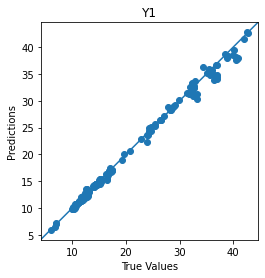

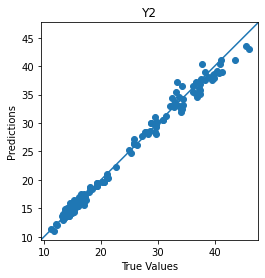

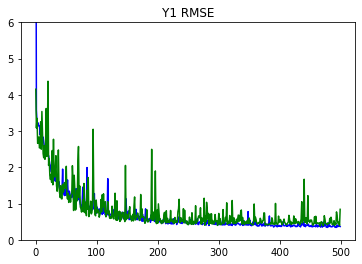

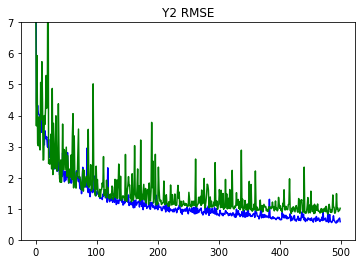

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)